# Load dataset

In [1]:
%load_ext autoreload
%autoreload 2

import os
from src.manifolds.geodesics_dataset import prepare_data, TrajGeodesicsDataset

seed = 42
batch_size = 4

struct = 1
data_folder = os.path.join('..', "data", "molecular_dynamics")
results_folder = 'results'

ca_pos = prepare_data(struct, data_folder)

Shape of full data: (102, 3341, 3) (L x N x D)
Shape of CA data: torch.Size([102, 214, 3]) (L x N x D)
Number of CA atoms: 214
Number of timesteps: 102
CA atom data dimensionality: 3 (should be 3 for 3D data)


# Uncorrected manifold

In [2]:
import torch

dataset = TrajGeodesicsDataset(ca_pos, window_size=10)
proteins = dataset.proteins
num_proteins = proteins.shape[0]
protein_len = proteins.shape[1]

t_steps = 21
p0 = proteins[0]
p1 = proteins[-1]
T = torch.linspace(0,1,t_steps)  # torch.tensor([1/4,1/2,3/4]) # torch.tensor([1/2])
pt = torch.zeros(t_steps, protein_len, 3)
mdt = torch.zeros(t_steps, protein_len, 3)
for i,t in enumerate(T):
    print(f"computing geodesic {i+1}")
    md_ind = int(i/(t_steps-1) * (num_proteins-1))
    pt[i] = dataset.manifold.s_geodesic(p0[None,None], p1[None,None], torch.tensor([t]), debug=True).squeeze()
    mdt[i] = proteins[md_ind]
    
%timeit dataset.manifold.s_geodesic(p0[None,None], p1[None,None], torch.tensor([T[int(t_steps/2)]]))

computing geodesic 1
1 | relerror = 1.3062254190444946
2 | relerror = 0.523198664188385
3 | relerror = 0.09502211213111877
4 | relerror = 0.006523800548166037
5 | relerror = 5.613053508568555e-05
computing geodesic 2
1 | relerror = 1.2423473596572876
2 | relerror = 0.473627507686615
3 | relerror = 0.08295956254005432
4 | relerror = 0.005844746250659227
5 | relerror = 5.6433385907439515e-05
computing geodesic 3
1 | relerror = 1.1384351253509521
2 | relerror = 0.4282507002353668
3 | relerror = 0.06348913162946701
4 | relerror = 0.0035799157340079546
5 | relerror = 4.3873489630641416e-05
computing geodesic 4
1 | relerror = 1.0604556798934937
2 | relerror = 0.38385024666786194
3 | relerror = 0.046048667281866074
4 | relerror = 0.0017538698157295585
5 | relerror = 3.361216658959165e-05
computing geodesic 5
1 | relerror = 0.9889010787010193
2 | relerror = 0.3400055468082428
3 | relerror = 0.03396626189351082
4 | relerror = 0.0010036323219537735
5 | relerror = 2.5623112378525548e-05
computing

<function matplotlib.pyplot.show(close=None, block=None)>

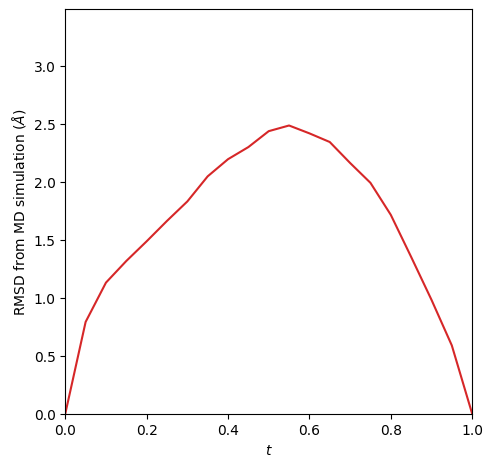

In [3]:
import matplotlib.pyplot as plt

# compute RMSD in Anstrom for geodesics vs trajectory
rmsd_T = torch.sqrt(torch.sum((pt - mdt) ** 2,[1,2]) / protein_len)

# plot 
fig_size = 21 # cm
plt.figure(figsize=(fig_size/4, fig_size/4))
plt.plot(T, rmsd_T, 'tab:red')
plt.xlim([0,1])
plt.ylim([0,rmsd_T.max()+1])
plt.xlabel(r'$t$')
plt.ylabel(r'RMSD from MD simulation ($\AA$)')
# save figure
formt = '.png'
#plt.savefig(os.path.join(results_folder, fig_prefix + f'_RMSD_progression_md' + formt))
plt.show

# Corrected manifold

In [54]:
from train_mc import LitDeepPointCloudMetric

ckpt_path = 'lightning_logs/loss_log_correction_l2_coeff_0.01/version_1/checkpoints/epoch=99-step=1700.ckpt'
model = LitDeepPointCloudMetric.load_from_checkpoint(ckpt_path)

In [55]:
from src.manifolds.corrected_pointcloud import CorrectedPointCloudManifold

n_pointclouds, n_atoms, atom_dim = ca_pos.shape
corrected_manifold = CorrectedPointCloudManifold(model.deep_metric_encoder, atom_dim, n_atoms, base=ca_pos[0], alpha=1., beta=0.)

In [ ]:
t_steps = 21
p0 = proteins[0]
p1 = proteins[-1]
T = torch.linspace(0,1,t_steps)  # torch.tensor([1/4,1/2,3/4]) # torch.tensor([1/2])
pt = torch.zeros(t_steps, protein_len, 3)
mdt = torch.zeros(t_steps, protein_len, 3)
for i,t in enumerate(T):
    print(f"computing geodesic {i+1}")
    md_ind = int(i/(t_steps-1) * (num_proteins-1))
    pt[i] = corrected_manifold.s_geodesic(p0[None,None], p1[None,None], torch.tensor([t]), step_size=0.1, debug=True).squeeze()
    mdt[i] = proteins[md_ind]
    
%timeit corrected_manifold.s_geodesic(p0[None,None], p1[None,None], torch.tensor([T[int(t_steps/2)]]))

computing geodesic 1
1 | relerror = 1.0118770599365234
2 | relerror = 0.9116297364234924
3 | relerror = 0.8208954930305481
4 | relerror = 0.7388800978660583
5 | relerror = 0.6648513674736023
6 | relerror = 0.5981116890907288
7 | relerror = 0.5380002856254578
8 | relerror = 0.4838942289352417
9 | relerror = 0.4352157711982727
10 | relerror = 0.39143264293670654
11 | relerror = 0.3520595133304596
12 | relerror = 0.3166549503803253
13 | relerror = 0.28481990098953247
14 | relerror = 0.25619447231292725
15 | relerror = 0.23045435547828674
16 | relerror = 0.2073078155517578
17 | relerror = 0.18649263679981232
18 | relerror = 0.1677730828523636
19 | relerror = 0.15093740820884705
20 | relerror = 0.13579517602920532
21 | relerror = 0.12217549979686737
22 | relerror = 0.10992471128702164
23 | relerror = 0.09890472888946533
24 | relerror = 0.08899152278900146
25 | relerror = 0.08007360249757767
26 | relerror = 0.07205072790384293
27 | relerror = 0.06483285129070282
28 | relerror = 0.05833896622

<function matplotlib.pyplot.show(close=None, block=None)>

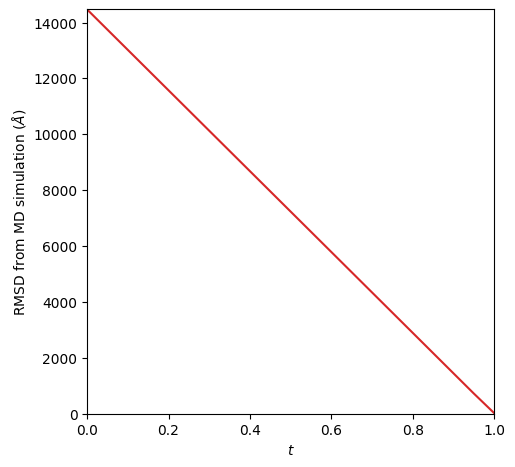

In [50]:
import matplotlib.pyplot as plt

# compute RMSD in Anstrom for geodesics vs trajectory
rmsd_T = torch.sqrt(torch.sum((pt - mdt) ** 2,[1,2]) / protein_len).detach()

# plot 
fig_size = 21 # cm
plt.figure(figsize=(fig_size/4, fig_size/4))
plt.plot(T, rmsd_T, 'tab:red')
plt.xlim([0,1])
plt.ylim([0,rmsd_T.max()+1])
plt.xlabel(r'$t$')
plt.ylabel(r'RMSD from MD simulation ($\AA$)')
# save figure
formt = '.png'
#plt.savefig(os.path.join(results_folder, fig_prefix + f'_RMSD_progression_md' + formt))
plt.show